In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import ImageColor
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_Columns', 100)

In [2]:
color = pd.read_csv('../input/color.csv')
color_rgb = pd.DataFrame(color['hex'].str.strip().map(ImageColor.getrgb).values.tolist(), 
                         columns=['color_r', 'color_g', 'color_b'])
color = pd.concat([color, color_rgb], axis=1)
print('color', color.shape)

color (73636, 6)


In [3]:
palette = pd.read_csv('../input/palette.csv')
print('palette', palette.shape)
material = pd.read_csv('../input/material.csv')
print('material', material.shape)
object_collection = pd.read_csv('../input/object_collection.csv')
print('object_collection', object_collection.shape)
technique = pd.read_csv('../input/technique.csv')
print('technique', technique.shape)
maker = pd.read_csv('../input/maker.csv')
print('maker', maker.shape)
principal_maker = pd.read_csv('../input/principal_maker.csv')
print('principal_maker', principal_maker.shape)
principal_maker_occupation = pd.read_csv('../input/principal_maker_occupation.csv')
print('principal_maker_occupation', principal_maker_occupation.shape)
train = pd.read_csv('../input/train.csv')
print('train', train.shape)
test = pd.read_csv('../input/test.csv')
print('test', test.shape)
whole = pd.concat([train, test])
print('whole', whole.shape)

palette (527890, 5)
material (35394, 2)
object_collection (14210, 2)
technique (20481, 2)
maker (3291, 6)
principal_maker (24538, 6)
principal_maker_occupation (25372, 2)
train (12026, 19)
test (12008, 18)
whole (24034, 19)


In [4]:
def create_numeric_feature(df_input):
    cp = df_input.copy()
    cp['acquisition_year'] = pd.to_datetime(df_input['acquisition_date']).dt.year
    return cp[['acquisition_year', 'dating_sorting_date', 'dating_period', 'dating_year_early', 'dating_year_late']]

In [5]:
def create_count_encoding_feature_sub(df_whole, df_input, column):
    cp = df_input.copy()
    newcol = 'CE_'+column
    group = df_whole.groupby(column).size().rename(newcol)
    group = pd.DataFrame(group).reset_index()
    cp = pd.merge(cp, group, on=column, how='left')
    return cp[[newcol]].fillna(0)

In [6]:
def create_count_encoding_feature(df_input):
    col_list = ['art_series_id', 'principal_maker', 'principal_or_first_maker', 
                'copyright_holder', 'acquisition_method', 'dating_sorting_date']
    cp = df_input.copy()
    org_col = cp.columns
    for col in col_list:
        tmp = create_count_encoding_feature_sub(whole, cp, col)
        cp = pd.concat([cp, tmp], axis=1)
    return cp.drop(columns=org_col)

In [7]:
def create_label_encoding_feature(df_input):
    col_list = ['art_series_id', 'principal_maker', 'principal_or_first_maker', 
                'copyright_holder', 'acquisition_method']
    out_df = pd.DataFrame()
    le = LabelEncoder()
    for col in col_list:
        le.fit(whole[col])
        out_df[col] = le.transform(df_input[col])
    return out_df.add_prefix('LE_')

In [8]:
def create_string_length_feature(df_input):
    out_df = pd.DataFrame()
    str_columns = ['title', 'long_title', 'sub_title', 'more_title', 'description']
    for c in str_columns:
        out_df[c] = df_input[c].str.len()
    return out_df.add_prefix('LN_')

In [9]:
def create_sub_title_feature(df_input):
    out = pd.DataFrame(index=df_input.index)
    for axis in ['h', 'w', 't', 'd']:
        column_name = f'size_{axis}'
        size_info = df_input['sub_title'].str.extract(r'{} (\d*|\d*\.\d*)(cm|mm)'.format(axis))
        size_info = size_info.rename(columns={0: column_name, 1: 'unit'})
        size_info[column_name] = size_info[column_name].replace('', np.nan).astype(float)
        size_info[column_name] = size_info.apply(lambda row: row[column_name] * 10 if row['unit'] == 'cm' else row[column_name], axis=1) 
        out[column_name] = size_info[column_name]
    return out

In [10]:
def create_all_feature(df_input):
    func_list = [
        create_numeric_feature,
        create_count_encoding_feature,
        create_label_encoding_feature,
        create_string_length_feature,
        create_sub_title_feature,
    ]
    out = pd.DataFrame(index=df_input.index)
    for func in func_list:
        out = pd.concat([out, func(df_input)], axis=1)
        
    assert len(df_input) == len(out)
    return out

In [11]:
def split_train_target(df_input):
    target = df_input[['likes']].copy()
    target['target'] = target['likes'].apply(lambda x: np.log1p(x))
    return target['target']

In [12]:
train_X = create_all_feature(train)
test_X = create_all_feature(test)
train_y = split_train_target(train)
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
feat_cnt = len(train_X.columns)

(12026, 25)
(12026,)
(12008, 25)


In [13]:
train_X.head()

,acquisition_year,dating_sorting_date,dating_period,dating_year_early,dating_year_late,CE_art_series_id,CE_principal_maker,CE_principal_or_first_maker,CE_copyright_holder,CE_acquisition_method,CE_dating_sorting_date,LE_art_series_id,LE_principal_maker,LE_principal_or_first_maker,LE_copyright_holder,LE_acquisition_method,LN_title,LN_long_title,LN_sub_title,LN_more_title,LN_description,size_h,size_w,size_t,size_d
0,1808.0,1660.0,17,1660.0,1685.0,1,5,5.0,0.0,8387.0,138.0,12962,1782,1793,42,5,21,48,39.0,21.0,NaN,665.0,537.0,25.0,47.0
1,2000.0,1900.0,19,1900.0,1930.0,1,364,364.0,364.0,8387.0,637.0,13131,2880,2899,39,5,15,64,17.0,15.0,NaN,165.0,223.0,NaN,NaN
2,2007.0,1860.0,19,1860.0,1880.0,1,1,1.0,0.0,3196.0,727.0,6653,3063,3082,42,2,21,52,15.0,21.0,46.0,87.0,56.0,NaN,NaN
3,1881.0,1850.0,19,1850.0,1879.0,1,1,1.0,0.0,1161.0,458.0,21814,404,406,42,0,16,53,25.0,16.0,71.0,1790.0,2480.0,40.0,NaN
4,1971.0,1825.0,19,1825.0,1874.0,1,3457,3373.0,0.0,2315.0,33.0,11266,3246,3267,42,7,27,51,27.0,27.0,28.0,130.0,175.0,NaN,7.0


In [14]:
LGBM_PARAM = {
    'objective' : 'regression',
    'boosting_type': 'gbdt',
    'metric' : 'rmse',
    'seed' : 0,
    'learning_rate':  0.1,
    'max_depth' : 6,
    'verbosity': -1
}
KFOLD = 4

In [15]:
def train_kfold(X, y, params=LGBM_PARAM, k_fold=KFOLD):
    rmse_list = []
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    kf = KFold(n_splits=k_fold, shuffle=True, random_state=0)
    for train_index, valid_index in kf.split(X):

        x_train, x_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        lgbm_train = lgbm.Dataset(x_train, y_train)
        lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
        lgbm_model = lgbm.train(params, 
                                                lgbm_train, 
                                                valid_sets=lgbm_eval,
                                                num_boost_round=10000,
                                                early_stopping_rounds=100,
                                                verbose_eval=-1)
        y_pred = lgbm_model.predict(x_valid, num_iteration=lgbm_model.best_iteration)
        oof_pred[valid_index] = y_pred

        rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

        rmse_list.append(rmse)
        models.append(lgbm_model)

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('- TRAIN RMSE={:.4f}'.format(score))

    return models, oof_pred, score

In [16]:
def predict_test(test_X, models):
    pred_list = []
    for model in models:
        pred = model.predict(test_X, num_iteration = model.best_iteration)
        pred_list.append(pred)
    pred_test = np.mean(pred_list, axis=0)
    return pred_test

In [17]:
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred

In [18]:
models, oof_pred, score = train_kfold(train_X, train_y)
pred = predict_test(test_X, models)
test_pred = revert_to_real(pred)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[216]	valid_0's rmse: 1.08341
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[142]	valid_0's rmse: 1.16831
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[158]	valid_0's rmse: 1.09589
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[2

In [19]:
df_test_pred = pd.DataFrame(test_pred, columns=['likes'])
assert len(df_test_pred) == len(test)
df_test_pred.to_csv('../output/submit.csv', index=False)
df_test_pred.head()

,likes
0,0.574629
1,32.604165
2,0.525244
3,4.335554
4,1.130891


In [20]:
def plot_scatter(target, oof):
    x1 = target
    y1 = oof
    xmax = max(max(x1), max(y1))*1.05
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(x1, y1, alpha=0.3, marker='.')
    ax.plot([0, xmax], [0, xmax], color='black', linewidth=0.5)
    plt.xlabel('Target')
    plt.ylabel('Out of fold')
    plt.xlim(0, xmax)
    plt.ylim(0, xmax)

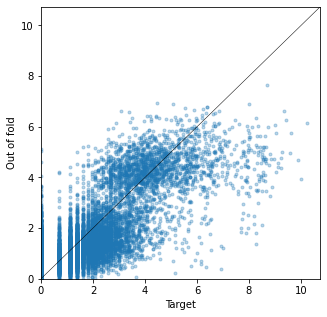

In [21]:
corr = train_y.corr(pd.Series(oof_pred))
plot_scatter(train_y, oof_pred)

In [22]:
def plot_hist(oof, pred):
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.histplot(pred, label='Test Predict', ax=ax, color='black')
    sns.histplot(oof, label='Out of fold', ax=ax, color='C1')
    ax.legend()
    ax.grid()

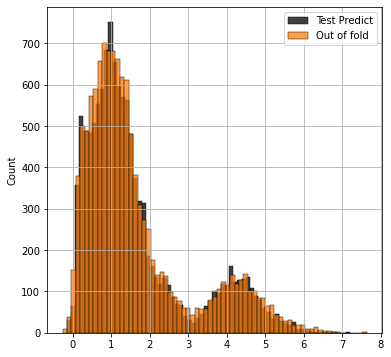

In [23]:
plot_hist(oof_pred, pred)

In [24]:
print('- feat_cnt =', feat_cnt)
print(f'- score = {score:.5f}')
print(f'- corr = {corr:.5f}')

- feat_cnt = 25
- score = 1.11432
- corr = 0.77827


#### baseline_1: size, string_length
- feat_cnt = 25
- score = 1.11432
- corr = 0.77827
- LB = 1.1037

#### baseline_0
- feat_cnt = 16
- score = 1.20651
- corr = 0.73332
- LB = 1.1827

In [25]:
def visualize_importance(models):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance()
        _df['column'] = model.feature_name()
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

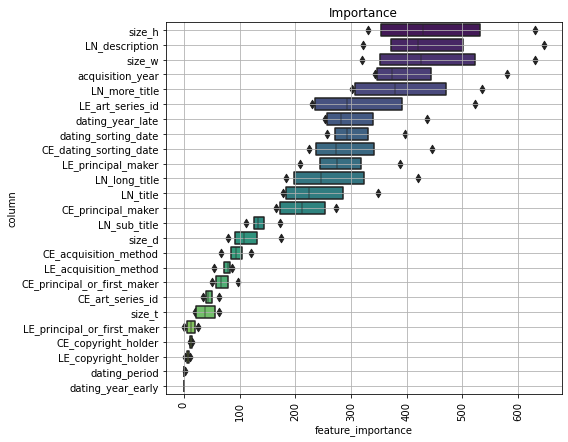

In [26]:
fig, ax = visualize_importance(models)